In [ ]:
# Install dependencies
%pip install lief==0.16.4
%pip install numpy==1.26.4
%pip install deap
%pip install pandas
%pip install matplotlib
%pip install tqdm
%pip install python-magic
# Install ML-Pentest Lib
%pip install ml-pentest
# Install EMBER augmented version
%pip install ember-mivia==0.0.6

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
print(np.__version__)

1.26.4


In [ ]:
%pip install pefile

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
"""
Classifying Sequences of Extreme Length with Constant Memory Applied to Malware Detection
Edward Raff, William Fleshman, Richard Zak, Hyrum Anderson and Bobby Filar and Mark Mclean
https://arxiv.org/abs/2012.09390
"""
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def drop_zeros_hook(module, grad_input, grad_out):
    """
    This function is used to replace gradients that are all zeros with None
    In pyTorch None will not get back-propogated
    So we use this as a approximation to saprse BP to avoid redundant and useless work
    """
    grads = []
    with torch.no_grad():
        for g in grad_input:
            if torch.nonzero(g).shape[0] == 0:
                grads.append(g.to_sparse())
            else:
                grads.append(g)

    return tuple(grads)


class CatMod(torch.nn.Module):
    def __init__(self):
        super(CatMod, self).__init__()

    def forward(self, x):
        return torch.cat(x, dim=2)


class LowMemConvBase(nn.Module):

    def __init__(self, chunk_size=65536, overlap=512, min_chunk_size=1024):
        """
        chunk_size: how many bytes at a time to process. Increasing may improve compute efficent, but use more memory. Total memory use will be a function of chunk_size, and not of the length of the input sequence L

        overlap: how many bytes of overlap to use between chunks

        """
        super(LowMemConvBase, self).__init__()
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.min_chunk_size = min_chunk_size

        #Used for pooling over time in a more efficent way
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.cat = CatMod()
        self.cat.register_backward_hook(drop_zeros_hook)
        self.receptive_field = None

        #Used to force checkpoint code to behave correctly due to poor design https://discuss.pytorch.org/t/checkpoint-with-no-grad-requiring-inputs-problem/19117/11
        self.dummy_tensor = torch.ones(1, dtype=torch.float32, requires_grad=True)

    def processRange(self, x, **kwargs):
        """
        This method does the work to convert an LongTensor input x of shape (B, L) , where B is the batch size and L is the length of the input. The output of this functoin should be a tensor of (B, C, L), where C is the number of channels, and L is again the input length (though its OK if it got a little shorter due to convs without padding or something).

        """
        pass

    def determinRF(self):
        """
        This function evaluates the receptive field & stride of our sub-network.
        """

        if self.receptive_field is not None:
            return self.receptive_field, self.stride, self.out_channels

        if not hasattr(self, "device_ids"):
            #We are training with just one device. Lets find out where we should move the data
            cur_device = next(self.embd.parameters()).device
        else:
            cur_device = "cpu"

        #Lets do a simple binary search to figure out how large our RF is.
        #It can't be larger than our chunk size! So use that as upper bound
        min_rf = 1
        max_rf = self.chunk_size

        with torch.no_grad():

            tmp = torch.zeros((1,max_rf)).long().to(cur_device)

            while True:
                test_size = (min_rf+max_rf)//2
                is_valid = True
                try:
                    self.processRange(tmp[:,0:test_size])
                except:
                    is_valid = False

                if is_valid:
                    max_rf = test_size
                else:
                    min_rf = test_size+1

                if max_rf == min_rf:
                    self.receptive_field = min_rf
                    out_shape = self.processRange(tmp).shape
                    self.stride = self.chunk_size//out_shape[2]
                    self.out_channels = out_shape[1]
                    break


        return self.receptive_field, self.stride, self.out_channels


    def pool_group(self, *args):
        x = self.cat(args)
        x = self.pooling(x)
        return x

    def seq2fix(self, x, pr_args={}):
        """
        Takes in an input LongTensor of (B, L) that will be converted to a fixed length representation (B, C),
        where C is the number of channels provided by the base_network given at construction.
        """

        receptive_window, stride, out_channels = self.determinRF()

        if x.shape[1] < receptive_window: #This is a tiny input! Pad it out
            x = F.pad(x, (0, receptive_window-x.shape[1]), value=0) # 0 is the pad value
        batch_size = x.shape[0]
        length = x.shape[1]

        #Let's go through the input data without gradients first, and find the positions that "win"
        #the max-pooling. Most of the gradients will be zero, and we don't want to waste valuable
        #memory and time computing them.
        #Once we know the winners, we will go back and compute the forward activations on JUST
        #the subset of positions that won!
        winner_values = np.zeros((batch_size, out_channels))-1.0
        winner_indices = np.zeros((batch_size, out_channels), dtype=np.int64)

        if not hasattr(self, "device_ids"):
            #We are training with just one device. Lets find out where we should move the data
            cur_device = next(self.embd.parameters()).device
        else:
            cur_device = None

        step = self.chunk_size #- self.overlap
        start = 0
        end = start+step

        with torch.no_grad():
            while start < end and (end-start) >= max(self.min_chunk_size, receptive_window):
                x_sub = x[:,start:end]
                if cur_device is not None:
                    x_sub = x_sub.to(cur_device)
                activs = self.processRange(x_sub.long(), **pr_args)
                activ_win, activ_indx = F.max_pool1d(activs, kernel_size=activs.shape[2], return_indices=True)
                #We want to remove only last dimension, but if batch size is 1, np.squeeze
                #will screw us up and remove first dim too.
                #activ_win = np.squeeze(activ_win.cpu().numpy())
                #activ_indx = np.squeeze(activ_indx.cpu().numpy())
                activ_win = activ_win.cpu().numpy()[:,:,0]
                activ_indx = activ_indx.cpu().numpy()[:,:,0]
                selected = winner_values < activ_win
                winner_indices[selected] = activ_indx[selected]*stride + start
                winner_values[selected]  = activ_win[selected]
                start = end
                end = min(start+step, length)

        # Now we know every index that won, we need to compute values and with gradients!

        # Find unique winners for every batch
        final_indices = [np.unique(winner_indices[b,:]) for b in range(batch_size)]

        # Collect inputs that won for each batch
        chunk_list = [[x[b:b+1,max(i-receptive_window,0):min(i+receptive_window,length)] for i in final_indices[b]] for b in range(batch_size)]
        # Convert to a torch tensor of the bytes
        chunk_list = [torch.cat(c, dim=1)[0,:] for c in chunk_list]

        # Pad out shorter sequences to the longest one
        x_selected = torch.nn.utils.rnn.pad_sequence(chunk_list, batch_first=True)

        # Shape is not (B, L). Compute it.
        if cur_device is not None:
            x_selected = x_selected.to(cur_device)
        x_selected = self.processRange(x_selected.long(), **pr_args)
        x_selected = self.pooling(x_selected)
        x_selected = x_selected.view(x_selected.size(0), -1)

        return x_selected


In [ ]:
import numpy as np                          # Libreria per array e operazioni numeriche
import torch                                # Libreria principale per deep learning
import torch.nn as nn                       # Moduli per costruire layer di rete
import torch.nn.functional as F             # Funzioni di attivazione, pooling, ecc.

# Funzione per convertire un array di interi in vettori binari normalizzati tra -1 e +1
#arr: un array NumPy di interi (qualsiasi forma multidimensionale).
#m: numero di bit desiderati per rappresentare ogni intero (default 8).
def vec_bin_array(arr, m=8):
    """
    Converte ogni intero positivo in un vettore binario di m bit.
    Restituisce float32 tra -0.0625 e +0.0625 per ogni bit.
    """

    #Crea una funzione “vectorizzata” che applica elemento-per-elemento una trasformazione Python su array NumPy.
    #np.binary_repr(x): lo converte in stringa binaria (ad es. 13 → "1101").
    #.zfill(m): se la stringa ha meno di m caratteri, la “riempie” con zeri a sinistra fino a lunghezza m
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))     # converte in stringhe binarie
    strs = to_str_func(arr) #Applica la funzione a tutto l’array arr, ottenendo un array di stringhe binarie con shape uguale a arr.shape.

    """Alloca un nuovo array NumPy di tipo int8 inizializzato a zero.

La forma (shape) è quella di arr, con un’ulteriore dimensione finale di lunghezza m.

Esempio: se arr.shape == (100, ) e m=8, allora ret.shape == (100, 8).

In ret verranno memorizzati i bit estratti (0 o 1)."""
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)                 # crea array shape [..., m]
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')        # estrae il bit in posizione bit_ix
        ret[..., bit_ix] = fetch_bit_func(strs).astype(np.int8)

    return (ret * 2 - 1).astype(np.float32) / 16                         # normalizza: da {0,1} → {-1,+1}/16

# Rete neurale convoluzionale ispirata a modelli antivirus (CNN profonda)
class AvastConv(LowMemConvBase):  # eredita la logica per gestire file lunghi e suddividerli in chunk
    def __init__(self, out_size=2, channels=48, window_size=32, stride=4, embd_size=8):
        super(AvastConv, self).__init__()  # inizializza la classe base LowMemConvBase

        # Layer di embedding: 1 vettore binario (lunghezza 8) per ogni byte (0–256)
        self.embd = nn.Embedding(257, embd_size, padding_idx=0)

        # Imposta l’embedding a valori binari normalizzati (non trainabile)
        for i in range(1, 257):
            self.embd.weight.data[i, :] = torch.tensor(vec_bin_array(np.asarray([i])))

        for param in self.embd.parameters():
            param.requires_grad = False  # impedisce al modello di aggiornare l’embedding

        # Primo strato convoluzionale: da 8 bit → canali base (48)
        self.conv_1 = nn.Conv1d(8, channels, window_size, stride=stride, bias=True)


        # Secondo strato convoluzionale: aumenta il numero di canali
        self.conv_2 = nn.Conv1d(channels, channels * 2, window_size, stride=stride, bias=True)


        # Max pooling per ridurre la lunghezza della sequenza (compressione)
        self.pool = nn.MaxPool1d(4)

        # Terzo e quarto layer convoluzionale: aumentano i canali e riducono la lunghezza
        self.conv_3 = nn.Conv1d(channels * 2, channels * 3, window_size // 2, stride=stride * 2, bias=True)


        self.conv_4 = nn.Conv1d(channels * 3, channels * 4, window_size // 2, stride=stride * 2, bias=True)


        # Fully Connected Layers per classificare dopo la convoluzione
        self.fc_1 = nn.Linear(channels * 4, channels * 4)
        self.fc_2 = nn.Linear(channels * 4, channels * 3)
        self.fc_3 = nn.Linear(channels * 3, channels * 2)
        self.fc_4 = nn.Linear(channels * 2, out_size)  # Output finale (es. 2 classi)

    # Metodo per processare un chunk singolo (usato da seq2fix)
    def processRange(self, x):
        with torch.no_grad():                        # embedding non deve calcolare gradienti
            x = self.embd(x)                         # da (B, L) → (B, L, 8)
            x = torch.transpose(x, -1, -2)           # da (B, L, 8) → (B, 8, L)

        x = F.relu(self.conv_1(x))                   # 1° convoluzione + ReLU
        x = F.relu(self.conv_2(x))                   # 2° convoluzione + ReLU
        x = self.pool(x)                             # max pooling → riduzione lunghezza
        x = F.relu(self.conv_3(x))                   # 3° convoluzione + ReLU
        x = F.relu(self.conv_4(x))                   # 4° convoluzione + ReLU


        return x                                     # ritorna il risultato convoluzionale

    # Metodo forward: prende l'intero input, lo divide in chunk, elabora, e classifica
    def forward(self, x):
        post_conv = x = self.seq2fix(x)              # suddivide input lungo, applica processRange + pooling

        x = F.selu(self.fc_1(x))                     # 1° FC + SELU
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.selu(self.fc_2(x))                     # 2° FC + SELU
        x = F.dropout(x, p=0.5, training=self.training)

        penult = x = F.selu(self.fc_3(x))            # 3° FC + SELU → salvato per analisi

        x = self.fc_4(x)                             # 4° FC → output finale

        #return torch.sigmoid(x)                      # output tra 0 e 1 (classificazione binaria)
        return x  # ritorna i logits, senza sigmoid



In [ ]:
from ml_pentest.models.wrappers.model_wrapper import ModelWrapper
from ml_pentest.models.feature_extractor.pe_format.ember_feature_extractor import get_ember_features_from_bytes

class AvastConvWrapper(ModelWrapper):
    def __init__(self, model, max_len: int = 2**20):
        super().__init__(model)
        self.max_len = max_len


    def classify_sample(self, sample_bytes: bytes) -> float:
        """
        sample_bytes: i byte grezzi del PE (read in modalità 'rb')
        Ritorna il logit “malware” (senza softmax) che serve
        all’attacco GammaSectionInjection.
        """
        # 1) Converto in array uint8
        arr = np.frombuffer(sample_bytes, dtype=np.uint8)

        # 2) Pad/trunca a self.max_len
        if len(arr) < self.max_len:
            padded = np.pad(arr, (0, self.max_len - len(arr)), mode='constant')
        else:
            padded = arr[: self.max_len]

        # 3) Riformo in (1, max_len) di tipo torch.Tensor
        #    Se usi PyTorch, fai:
        tensor = torch.from_numpy(padded).to(torch.uint8).unsqueeze(0)  # shape (1, max_len)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        tensor = tensor.to(device)


        # 4) Inoltro al modello:
        #       logits = model(tensor)       # restituisce shape (1, 1)
        #    e che quel valore sia il logit pre‐softmax.
        with torch.no_grad():
            logits = self._model(tensor)          # es. tensor di shape (1,1)
        # Estraggo il logit come float Python
        # 5) Applico la sigmoid per ottenere la probabilità
        prob_malware = torch.sigmoid(logits).item()

        return prob_malware


In [ ]:
import torch
# WRAPPER DEFINITION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AvastConv(out_size=1, channels=32, window_size=32, stride=4, embd_size=8)

model.load_state_dict(torch.load("/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Deep Model/Deep_Model_migliore.pt", map_location=device))
model = model.to(device)

model_wrapper = AvastConvWrapper(model, max_len=2 ** 20)

In [ ]:
test_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/test/malware"
output_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/GAMMA/gamma_obfuscated"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import pefile
import lief
import io
import contextlib

correct_malware = []
for fname in os.listdir(test_dir):
    if len(correct_malware) >= 100:
        break

    path = os.path.join(test_dir, fname)

    try:
        pe = pefile.PE(path)
    except pefile.PEFormatError:
        continue

    stderr_buf = io.StringIO()
    try:
      with contextlib.redirect_stderr(stderr_buf):
        binary = lief.parse(path)
        if binary is None:
            continue
    except Exception:
        continue

    # Se c’è QUALSIASI warning/log su stderr, skippa
    if stderr_buf.getvalue():
        continue

    try:
        with open(path, "rb") as f:
            sample_bytes = f.read()
    except Exception:
        continue  # file non leggibile, lo saltiamo

    proba = model_wrapper.classify_sample(sample_bytes)
    if proba > 0.5:
        correct_malware.append((path, sample_bytes))


In [ ]:
import os
import torch
import lief
import numpy as np
import random

In [ ]:
from ml_pentest.attacks.blackbox.genetic_attack.GAMMA.attack_utils import create_section_population_from_folder

# ATTACK PARAMETER DEFINITION
# Section extraction
how_many = 100 # how many section to extract from benign files
benign_path = '/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset2/general/benign' # path of benign files
sections_to_extract = ['.data','.rdata', '.idata', '.rodata', '.rsrc', '.reloc'] # name of section to extract

section_population, _ = create_section_population_from_folder(benign_path, how_many, sections_to_extract=sections_to_extract)
print("Section extracted")

Section extracted


In [ ]:
from ml_pentest.attacks.blackbox.genetic_attack.GAMMA.gamma_section_injection import GammaSectionInjection
import numpy as np
import time
import os
import shutil
import pandas as pd

# === CONFIGURAZIONE ===
lambda_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
POPULATION_SIZE = 20
ITERATIONS = 100
STAGNATION = 5
QUERY_BUDGET = 800


base_output_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/GAMMA/DeepExp"
experiment_dir = os.path.join(base_output_dir, "gamma_obfuscated/Experiment5")
results_dir = os.path.join(base_output_dir, "results/experiment5")
os.makedirs(results_dir, exist_ok=True)

partial_csv = os.path.join(results_dir, "gamma_lambda_results_partial.csv")

# Se esiste già un CSV parziale, lo carichi e continui da lì:
if os.path.exists(partial_csv):
    df_partial = pd.read_csv(partial_csv)
    # Prendi i λ già completati
    completed = set(df_partial["lambda"].unique())
    # Filtra la lista
    lambda_list = [l for l in lambda_list if l not in completed]
    lambda_results = df_partial.to_dict("records")
else:
    lambda_results = []

for lambda_val in lambda_list:
    print(f"\n🧪 Inizio attacco GAMMA con λ = {lambda_val}")
    attack_id = f"lambda{lambda_val:.0e}"
    output_dir = os.path.join(experiment_dir, attack_id)
    os.makedirs(output_dir, exist_ok=True)
    counterB =0
    SEED = 52

    for i, (path, original_bytes) in enumerate(correct_malware, start=1):
        fname = os.path.basename(path)
        print(f"\n🚀 Attacco su sample {i}/{len(correct_malware)} | File: {fname}")
        seed = SEED + i
        try:
            x = np.frombuffer(original_bytes, dtype=np.uint8)
            attack = GammaSectionInjection(
                section_population=section_population,
                model_wrapper=model_wrapper,
                population_size=POPULATION_SIZE,
                lambda_value=lambda_val,
                iterations=ITERATIONS,
                query_budget=QUERY_BUDGET,
                seed = SEED,
                stagnation=STAGNATION
            )
            attack.set_sample(x)
            start = time.time()
            result = attack.run()
            elapsed = time.time() - start
            adv_arr = result.get_adv_sample()
            adv_bytes = bytes(adv_arr)
            final_prob = model_wrapper.classify_sample(adv_bytes)
            if final_prob <= 0.5:
                counterB= counterB+1
                label = "benign"
            else: label= "malware"
            injected_bytes = len(adv_bytes) - len(original_bytes)

            # Memorizza il risultato
            lambda_results.append({
                "sample": fname,
                "lambda": lambda_val,
                "elapsed_time": elapsed,
                "queries": result.get_queries(),
                "iterations": result.get_iterations(),
                "final_prob": final_prob,
                "label": label,
                "injected_bytes": injected_bytes
            })

            # Salva l’esempio adversario
            with open(os.path.join(output_dir, fname), "wb") as f:
                f.write(adv_bytes)

            print(f"✅ Evasione: {label} (p={final_prob:.3f}), "
              f"time={elapsed:.1f}s, queries={result.get_queries()}")

        except Exception as e:
            print(f"❌ Errore su sample {i} (λ={lambda_val}): {e}")

    # Alla fine di questo λ, scrivo il CSV parziale
    pd.DataFrame(lambda_results).to_csv(partial_csv, index=False)
    print(f"Malware evasi con lambda {lambda_val}: {counterB}")
    print(f"💾 Checkpoint salvato in: {partial_csv}")



🧪 Inizio attacco GAMMA con λ = 0.0001

🚀 Attacco su sample 1/100 | File: 5b36bdf001f17ace83ca296a637d7606f9d3cd229d9496e5628b0f3fe934b087
✅ Evasione: malware (p=0.827), time=65.9s, queries=800

🚀 Attacco su sample 2/100 | File: 0e598845af1551516b66f38b9819736b43efef3625a90ebdd9d38466e0567430
✅ Evasione: malware (p=0.817), time=28.4s, queries=800

🚀 Attacco su sample 3/100 | File: 7d4dc47cad362ef362b0ca466c5d07a1edc50d38167044f7caafb249d130ea0f
✅ Evasione: malware (p=0.818), time=28.1s, queries=800

🚀 Attacco su sample 4/100 | File: 724d8b6d2607e4b603ca76b0ae36e62d01d906761b618902b0b8e8697cfad78d
✅ Evasione: malware (p=0.836), time=54.1s, queries=800

🚀 Attacco su sample 5/100 | File: 7deba23b1c81dd9b58d0e330724104a355ddec14b4d95395d9b615b9e537ffac
✅ Evasione: malware (p=0.807), time=18.8s, queries=620

🚀 Attacco su sample 6/100 | File: 8a594e5f71041d78753ae48da4b0bf269d4bbbf03d063b8299460cde1afe3f13
✅ Evasione: malware (p=0.790), time=28.8s, queries=800

🚀 Attacco su sample 7/100 | Fi

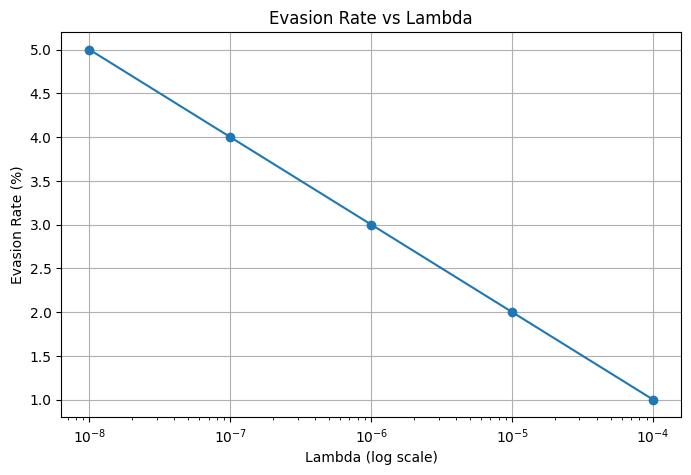

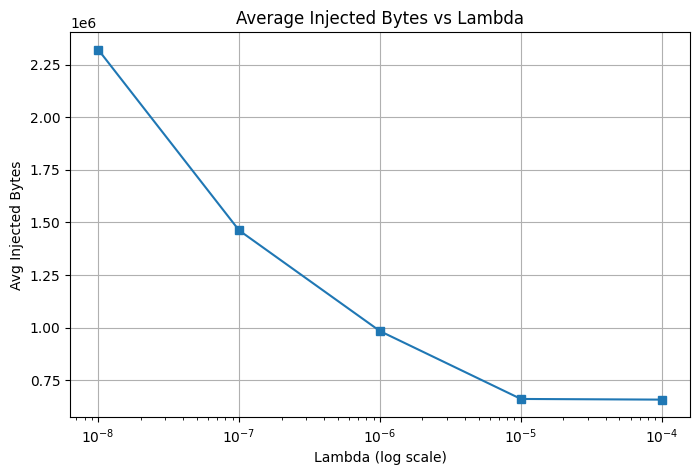

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Percorso del CSV parziale
results_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/GAMMA/DeepExp/results/experiment5"
partial_csv = os.path.join(results_dir, "gamma_lambda_results_partial.csv")

# 2. Carica i dati
df = pd.read_csv(partial_csv)

# 3. Grafico: Evasion Rate vs Lambda
plt.figure(figsize=(8, 5))
evasion_rates = df.groupby("lambda")["label"].apply(lambda x: (x == "benign").mean() * 100)
plt.plot(evasion_rates.index, evasion_rates.values, marker="o")
plt.xscale("log")
plt.title("Evasion Rate vs Lambda")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Evasion Rate (%)")
plt.grid(True)
plt.show()

# 4. Grafico: Average Injected Bytes vs Lambda
plt.figure(figsize=(8, 5))
mean_bytes = df.groupby("lambda")["injected_bytes"].mean()
plt.plot(mean_bytes.index, mean_bytes.values, marker="s")
plt.xscale("log")
plt.title("Average Injected Bytes vs Lambda")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Avg Injected Bytes")
plt.grid(True)
plt.show()

In [ ]:
# Tabella: media dei byte iniettati per valore di lambda
table_injected = df.groupby("lambda")["injected_bytes"].agg(["mean", "std", "min", "max", "count"])
table_injected = table_injected.rename(columns={
    "mean": "Mean Injected Bytes",
    "std": "Std Dev",
    "min": "Min",
    "max": "Max",
    "count": "Samples"
})
print("\n📊 Mean Injected Bytes per Lambda:")
print(table_injected)

table_injected.to_csv("/content/drive/Shareddrives/AI for Cybersecurity/Consegna/GAMMA/DeepExp/results/experiment5/tabella_injected_bytes.csv")


📊 Mean Injected Bytes per Lambda:
              Mean Injected Bytes        Std Dev      Min      Max  Samples
lambda                                                                     
1.000000e-08           2321018.88  393119.558005  1388544  3235840      100
1.000000e-07           1461688.32  309898.712180   810496  2576896      100
1.000000e-06            982758.40  152478.215835   584192  1288192      100
1.000000e-05            660367.36  124545.397605   547840   983040      100
1.000000e-04            657208.32  102707.459746   562688   966656      100


In [ ]:
# Converti tutte le colonne di misura in kilobyte
table_injected_kb = df.groupby("lambda")["injected_bytes"].agg(["mean", "std", "min", "max", "count"])
table_injected_kb /= 1024  # Converti tutti i valori in KB

table_injected_kb = table_injected_kb.rename(columns={
    "mean": "Mean Injected KB",
    "std": "Std Dev (KB)",
    "min": "Min (KB)",
    "max": "Max (KB)",
    "count": "Samples"
})

print("\n📊 Mean Injected Bytes per Lambda (in KB):")
print(table_injected_kb.round(2))

# (Opzionale) Salva anche su file CSV
table_injected_kb.to_csv("/content/drive/Shareddrives/AI for Cybersecurity/Consegna/GAMMA/DeepExp/results/experiment5/tabella_injected_kilobytes.csv")



📊 Mean Injected Bytes per Lambda (in KB):
              Mean Injected KB  Std Dev (KB)  Min (KB)  Max (KB)  Samples
lambda                                                                   
1.000000e-08           2266.62        383.91    1356.0    3160.0      0.1
1.000000e-07           1427.43        302.64     791.5    2516.5      0.1
1.000000e-06            959.72        148.90     570.5    1258.0      0.1
1.000000e-05            644.89        121.63     535.0     960.0      0.1
1.000000e-04            641.80        100.30     549.5     944.0      0.1


In [ ]:
############################################################################## CODICE DA TESTARE ANCORA